<a href="https://colab.research.google.com/github/grace3999/wireless_fiber_photometry/blob/master/FP_PDsingle_TTL_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from numpy import trapz

from scipy import ndimage
from scipy import signal as ss
from scipy.optimize import curve_fit

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

#### Get paths - separate folders for each day/animal

In [6]:
outer_path = '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort1/PDT/forced'

outer_file_list = os.listdir(outer_path)

outer_path_list = []

for name in outer_file_list:
    int_path = outer_path + '/' + name
    outer_path_list.append(int_path)

print(len(outer_path_list))
outer_path_list[0:3]

44


['/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort1/PDT/forced/PDT_75.1_1610_211129',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort1/PDT/forced/PDT_75.1_1609_211129',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort1/PDT/forced/PDT_75.1_1597_211130']

### Game plan:

- read in fiber photometry and TTL txt files and combine into dataframe
- convert TTL logic into event info
- create list of trial times  based on event info
- use trial times to make 1 trace per trial containing:
  - 10 seconds baseline (previous ITI)
  - 5 seconds lever extend -> lever press
  - 5 seconds lever press -> head entry for pellet
  - 10 seconds postline (start of ITI)

In [ ]:
# ITI ends                        10 seconds prior to HE trial start
# HE/levers extend                times_lever_extend = []
# lever press/reward/ITI start    times_ITI_start = []
# reward HE                       times_HE_pellet = []
# ITI ends                        20 seconds after reward HE

# ITI start -> levers extend (head entry) -> lever press (reward) -> ITI start

#make_FP_TTL_list(path)                                                                return FP_TTL_list
#make_df_from_file_list(FP_TTL_list)                                                   return TTL_dataframe
#make_event_from_TTL(TTL_dataframe)                                                    return TTL_dataframe_session
#get_trial_times(TTL_dataframe_session)                                                return times_lever_extend, times_lever_press, times_pellet, times_HE_pellet
#make_times_df(times_lever_extend, times_lever_press, times_pellet, times_HE_pellet)   return times_df
#make_trials_df(times_df, TTL_dataframe_session)                                       return trials_df

### Functions

In [7]:
def make_FP_TTL_list(path):
  TTL_list = []
  FP_list = []

  inner_file_list = os.listdir(outer_path)
    
  for inner_file in inner_file_list:
        
      if inner_file.split('.')[-1]=='TXT':
          int_path = outer_path + '/' + inner_file
          TTL_list.append(int_path)
      else:
          int_path = outer_path + '/' + inner_file
          FP_list.append(int_path)
            
  FP_TTL_list = list(zip(sorted(FP_list), sorted(TTL_list)))

  return FP_TTL_list

In [8]:
def make_df_from_file_list(FP_TTL_list):

  TTL_dataframe = pd.DataFrame(columns=['FP_signal', 'TTL'])
  
  i=0

  for file_pair in FP_TTL_list:

    #get meta data from file path
    task = file_pair[0].split('/')[-2].split('_')[0]
    session = file_pair[0].split('/')[-2].split('_')[1]
    animal = file_pair[0].split('/')[-2].split('_')[2]
    date = file_pair[0].split('/')[-2].split('_')[3]

    #get FP and TTL data and convert to list and put in dataframe
    data_int_file = pd.DataFrame(columns=['FP_signal', 'TTL'])
    
    #FP data
    data_FP = pd.melt(pd.read_table(file_pair[0], header=None).T)
    #TTL data
    data_TTL = pd.melt(pd.read_table(file_pair[1], header=None).T)

    data_int_file['FP_signal'] = data_FP['value']
    data_int_file['TTL'] = data_TTL['value']
    data_int_file['file'] = i

    TTL_dataframe = pd.concat([TTL_dataframe, data_int_file], ignore_index=True)
    
    TTL_dataframe['date'] = date
    TTL_dataframe['task'] = task
    TTL_dataframe['session'] = session
    TTL_dataframe['animal'] = animal
      
    i+=1

  return TTL_dataframe

In [10]:
def make_event_from_TTL(TTL_dataframe):
  
  TTL_dataframe = TTL_dataframe.reset_index().sort_values('index')
  TTL_dataframe['binary'] = [format(x, "08b") for x in TTL_dataframe['TTL']]

  TTL_prior = list(TTL_dataframe['binary'][0:-1])
  TTL_prior.insert(0,np.nan)
  TTL_dataframe['binary_prior'] = TTL_prior

  TTL_dataframe['binary_start'] = TTL_dataframe.apply(lambda x : 0 if x['binary'] == x['binary_prior'] else x['binary'], axis=1)

  #reset index to get time column

  TTL_dataframe['head_entry'] = [x[7] for x in TTL_dataframe['binary']]
  TTL_dataframe['left_extend'] = [x[6] for x in TTL_dataframe['binary']]
  TTL_dataframe['right_extend'] = [x[5] for x in TTL_dataframe['binary']]
  TTL_dataframe['left_press'] = [x[4] for x in TTL_dataframe['binary']]
  TTL_dataframe['right_press'] = [x[3] for x in TTL_dataframe['binary']]
  TTL_dataframe['pellet'] = [x[2] for x in TTL_dataframe['binary']]
  TTL_dataframe['session_start'] = [x[1] for x in TTL_dataframe['binary']]
  TTL_dataframe['ITI_start'] = [x[0] for x in TTL_dataframe['binary']]

  #remove start of data 
  start = TTL_dataframe[(TTL_dataframe['binary_start']!=0)&(TTL_dataframe['session_start']=='0')]['index'].values[0]
  TTL_dataframe_session = TTL_dataframe[(TTL_dataframe['index']>=start)]
  TTL_dataframe_session['session_time'] = np.arange(0, TTL_dataframe_session.shape[0])

  return TTL_dataframe_session

In [11]:
def get_trial_times(TTL_dataframe_session):

  times_lever_extend = []
  times_lever_press = []
  times_pellet = []
  times_HE_pellet = []

  times = TTL_dataframe_session[(TTL_dataframe_session['binary_start']!=0)&((TTL_dataframe_session['right_extend']=='0')|(TTL_dataframe_session['left_extend']=='0'))]['session_time'].values
  prev_time = -5000
  for time in times:
  
    if time - prev_time < 5000:
      print('skip')
      continue

    if time - prev_time > 5000:
      times_lever_extend.append((time))

      #find first lever press (ITI start) after lever extend
      df_after_extend = TTL_dataframe_session[TTL_dataframe_session['session_time']>=time]
      try:
        extend_press_time = df_after_extend[(df_after_extend['binary_start']!=0)&((df_after_extend['right_press']=='0')|(df_after_extend['left_press']=='0'))]['session_time'].values[0]
        #must press in 10 seconds
        if extend_press_time < (time+10000):
          times_lever_press.append(extend_press_time)

          #find first pellet after lever press (ITI start)
          df_after_press = df_after_extend[df_after_extend['session_time']>=extend_press_time]
          try:
            #should happen within seconds
            press_pellet_time = df_after_press[(df_after_press['binary_start']!=0)&(df_after_press['pellet']=='0')]['session_time'].values[0]
            if press_pellet_time < (extend_press_time+5000):
              times_pellet.append(press_pellet_time)

              #find first HE after lever press (ITI start) 
              df_after_pellet = df_after_press[df_after_press['session_time']>=press_pellet_time]
              try:
              #should happen within seconds
                pellet_HE_time = df_after_pellet[(df_after_pellet['binary_start']!=0)&(df_after_pellet['head_entry']=='0')]['session_time'].values[0]
                if pellet_HE_time < (press_pellet_time+5000):
                  times_HE_pellet.append(pellet_HE_time)

                else:
                  times_HE_pellet.append(np.nan)
              except: 
                times_HE_pellet.append(np.nan)

            else:
              times_pellet.append(np.nan)
              times_HE_pellet.append(np.nan)
          except: 
            times_pellet.append(np.nan)
            times_HE_pellet.append(np.nan)

        else:
          times_lever_press.append(np.nan)
          times_HE_pellet.append(np.nan)
          times_pellet.append(np.nan)
      except: 
        times_lever_press.append(np.nan)
        times_HE_pellet.append(np.nan)
        times_pellet.append(np.nan)

    prev_time = time

  return times_lever_extend, times_lever_press, times_pellet, times_HE_pellet

In [12]:
def make_times_df(times_lever_extend, times_lever_press, times_pellet, times_HE_pellet):

  times_df = pd.DataFrame(data=[times_lever_extend, times_lever_press, times_pellet, times_HE_pellet]).T
  times_df.columns = ['times_lever_extend', 'times_lever_press', 'times_pellet', 'times_HE_pellet']

  times_df['times_trial_start'] = times_df['times_lever_extend'] - 10000
  times_df.loc[times_df['times_trial_start']<0, 'times_trial_start'] = 0

  times_df['times_trial_end'] = times_df['times_lever_press'] + 10000
  times_df['trial'] = np.arange(0, times_df.shape[0])

  times_df['diff_press'] = times_df['times_lever_press'] - times_df['times_lever_extend']
  times_df['diff_pellet'] = times_df['times_pellet'] - times_df['times_lever_press']
  times_df['diff_HE'] = times_df['times_HE_pellet'] - times_df['times_pellet']
  times_df['diff_trial'] = times_df['times_trial_end'] - times_df['times_trial_start']

  times_df.loc[times_df['times_lever_press'].isna(), 'no_press'] = '1'
  times_df.loc[times_df['times_pellet'].isna(), 'no_pellet'] = 1

  times_df = times_df[['trial', 'no_press', 'no_pellet', 
           'times_trial_start', 'times_lever_extend', 'times_lever_press', 'times_pellet', 'times_HE_pellet', 'times_trial_end',
           'diff_press', 'diff_pellet', 'diff_HE', 'diff_trial']]

  return times_df

In [38]:
def make_trials_df(times_df, TTL_dataframe_session):

  trials_df = pd.DataFrame()

  i=0
  for time in times_df['times_lever_extend'].unique():
    
    start = times_df['times_trial_start'][i]
    extend = times_df['times_lever_extend'][i]
    press = times_df['times_lever_press'][i]
    HE = times_df['times_HE_pellet'][i]
    end = times_df['times_trial_end'][i]

    df_start_extend = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=start) & (TTL_dataframe_session['session_time']<extend)].sort_values('session_time')
    df_start_extend_resample = ss.resample(x=df_start_extend['FP_signal'].values, num=10000)

    df_extend_press = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=extend) & (TTL_dataframe_session['session_time']<press)].sort_values('session_time')
    df_extend_press_resample = ss.resample(x=df_extend_press['FP_signal'].values, num=5000)

    df_press_HE = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=press) & (TTL_dataframe_session['session_time']<HE)].sort_values('session_time')
    df_press_HE_resample = ss.resample(x=df_press_HE['FP_signal'].values, num=5000)

    df_HE_end = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=HE) & (TTL_dataframe_session['session_time']<end)].sort_values('session_time')
    df_HE_end_resample = ss.resample(x=df_HE_end['FP_signal'].values, num=10000)

    trace_final = np.concatenate((df_start_extend_resample, df_extend_press_resample, df_press_HE_resample, df_HE_end_resample), axis=0)

    trials_df_int = pd.DataFrame(columns=['FP_signal'])
    trials_df_int['FP_signal'] = trace_final
    trials_df_int['index'] = np.arange(0, trials_df_int.shape[0])/1000
    trials_df_int['trial'] = i
    trials_df_int['trial_start'] = start

    i+=1

    if trials_df.shape[0] == 0:
      trials_df = trials_df_int
    else:
      trials_df = pd.concat([trials_df, trials_df_int], ignore_index=True)

  return trials_df

In [ ]:
times_dir_dataframe = pd.DataFrame()
trials_dir_dataframe = pd.DataFrame()

for outer_path in outer_path_list[0:1]:

    print(outer_path, '\n')

    #make list of file paths and zip TTL and FP files
    print('Making file list...')

    if outer_path.split('/') == '.DS_Store':
        continue

    FP_TTL_list = make_FP_TTL_list(outer_path)

    #Combine data from all files and create df
    print('Creating data frame from files...')
    TTL_dataframe = make_df_from_file_list(FP_TTL_list)

    #create TTL_prior and then use to mark start of new TTLs
    print('Expanding TTLs...')
    TTL_dataframe_session = make_event_from_TTL(TTL_dataframe)

    #get trial times for each event of interest
    print('Collecting event times...')
    times_lever_extend, times_lever_press, times_pellet, times_HE_pellet = get_trial_times(TTL_dataframe_session)   
    times_df = make_times_df(times_lever_extend, times_lever_press, times_pellet, times_HE_pellet)
    print('Trial count: ', times_df['trial'].max())

    if times_dir_dataframe.shape[0] == 0:
      times_dir_dataframe = times_df
    else:
      times_dir_dataframe = pd.concat([times_dir_dataframe, times_df], ignore_index=True)

    #upsample/downsample to put all trials on same time scale
    print('Creating normalized trials...')
    trials_df = make_trials_df(times_df, TTL_dataframe_session)  

    trials_df['date'] = TTL_dataframe_session['date'].unique()[0]
    trials_df['task'] = TTL_dataframe_session['task'].unique()[0]
    trials_df['session'] = TTL_dataframe_session['session'].unique()[0]
    trials_df['animal'] = TTL_dataframe_session['animal'].unique()[0]
    print('Trial count: ', trials_df['trial'].max())

    if trials_dir_dataframe.shape[0] == 0:
      trials_dir_dataframe = trials_df
    else:
      trials_dir_dataframe = pd.concat([trials_dir_dataframe, trials_df], ignore_index=True)

    print('\n')

print(times_dir_dataframe.shape)
print(trials_dir_dataframe.shape)

times_dir_dataframe.head()

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort1/PDT/forced/PDT_75.1_1610_211129 

Making file list...
Creating data frame from files...
Expanding TTLs...


In [ ]:
times_dir_dataframe.median()

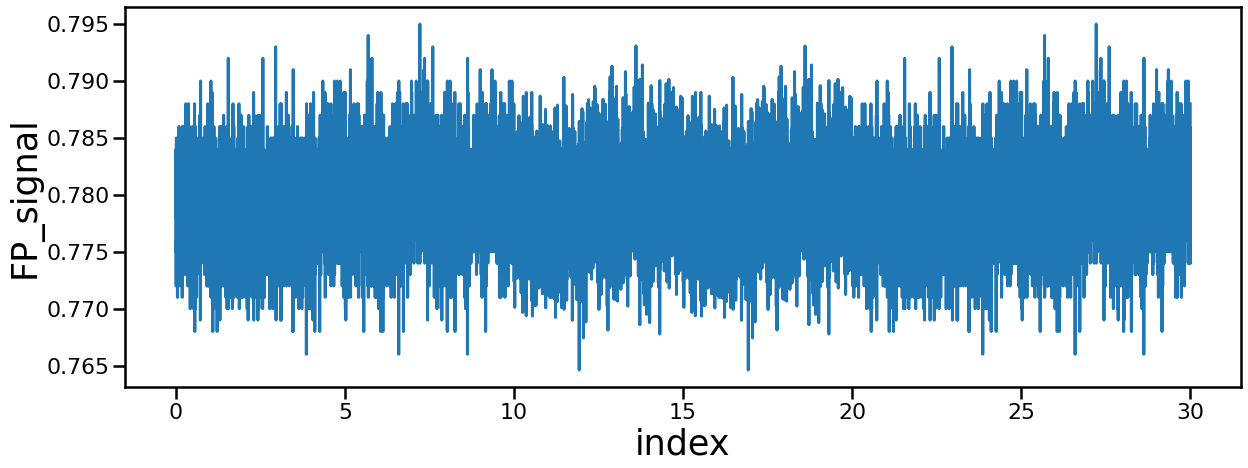

In [37]:
plt.figure(figsize=(20,7))
sns.lineplot(x='index', y='FP_signal', data=trials_dir_dataframe, ci=None, n_boot=1, markers=True)
plt.show()

In [39]:
i=3
start = df['times_trial_start'][i]
extend = df['times_lever_extend'][i]
press = df['times_lever_press'][i]
HE = df['times_HE_pellet'][i]
end = df['times_trial_end'][i]

df_start_extend = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=start) & (TTL_dataframe_session['session_time']<extend)].sort_values('session_time')
df_start_extend_resample = ss.resample(x=df_start_extend['FP_signal'].values, num=10000)

df_extend_press = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=extend) & (TTL_dataframe_session['session_time']<press)].sort_values('session_time')
df_extend_press_resample = ss.resample(x=df_start_extend['FP_signal'].values, num=5000)


df_press_HE = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=press) & (TTL_dataframe_session['session_time']<HE)].sort_values('session_time')
df_press_HE_resample = ss.resample(x=df_start_extend['FP_signal'].values, num=5000)


df_HE_end = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=HE) & (TTL_dataframe_session['session_time']<end)].sort_values('session_time')
df_HE_end_resample = ss.resample(x=df_start_extend['FP_signal'].values, num=10000)

In [40]:
trace_final = np.concatenate((df_start_extend_resample, df_extend_press_resample, df_press_HE_resample, df_HE_end_resample), axis=0)

df_trace = pd.DataFrame(columns=['FP_signal'])
df_trace['FP_signal'] = trace_final
df_trace['index'] = np.arange(0, df_trace.shape[0])/1000

df_trace.head()

,FP_signal,index
0,0.834,0.000
1,0.837,0.001
2,0.838,0.002
3,0.842,0.003
4,0.841,0.004


In [ ]:
def peri_event_simple(data, time, total_time, baseline_time):
    
    #time = time when event happens
    #total_time = total length of peri event
    #baseline_time = baseline duration (assumed that this should be taken from immediately prior to the event)
    
    start_time = time - baseline_time 
    end_time = start_time + total_time 
    
    #get peri event signal
    data_int = data[(data['session_time'] >= start_time) & (data['session_time'] < (end_time))]
    data_int['event_time'] = np.arange(0, data_int.shape[0]) / 1000

    #apply 5hz lowpass filter 
    b, a = ss.butter(4, 20, 'low', fs=1000) 
    FP_signal_5hz = ss.filtfilt(b, a, data_int['FP_signal'])
    data_int['FP_signal_5hz'] = FP_signal_5hz

    #detrend
    FP_signal_detrend = ss.detrend(data_int['FP_signal']) 
    data_int['FP_signal_detrend'] = FP_signal_detrend

    FP_signal_5hz_detrend = ss.detrend(data_int['FP_signal_5hz']) 
    data_int['FP_signal_5hz_detrend'] = FP_signal_5hz_detrend
    FP_signal_detrend_5hz = ss.filtfilt(b, a, data_int['FP_signal_detrend'])
    data_int['FP_signal_detrend_5hz'] = FP_signal_detrend_5hz

    #z score across trace
    numerator = np.subtract(data_int['FP_signal_5hz_detrend'], np.nanmean(data_int['FP_signal_5hz_detrend']))
    zscore = np.divide(numerator, np.nanstd(data_int['FP_signal_5hz_detrend']))
    data_int['zscore'] = zscore

    baseline = np.nanmedian(data_int[(data_int['session_time'] >= start_time) & (data_int['session_time'] < (time))]['FP_signal_5hz_detrend'].values)
    baselineSub = np.subtract(zscore, baseline)
    data_int['baseline_FP_signal_5hz_detrend'] = baselineSub

    baseline = np.nanmean(data_int[(data_int['session_time'] >= start_time) & (data_int['session_time'] < (time))]['zscore'].values)
    baselineSub = np.subtract(zscore, baseline)
    data_int['baseline_FP_signal_5hz_detrend_zscore'] = baselineSub

    #median filter to remove disconnects
    result = ndimage.median_filter(data_int['baseline_FP_signal_5hz_detrend'].values, size=100)
    data_int['FP_signal_medfilt'] = result

    return data_int

In [ ]:
def peri_event_df(TTL_dataframe_session, event_col):
    
    times_int = TTL_dataframe_session[(TTL_dataframe_session['binary_start']!=0)&(TTL_dataframe_session[event_col]=='0')]['session_time'].values
    #print(times_int)
    
    i=0
    prev_time=6000
    data_final_int = pd.DataFrame()
    for time in times_int:
      if time - prev_time < 5000:
        print('skip')
        continue
      if time - prev_time > 5000:
        data_int_peri = peri_event_simple(TTL_dataframe_session, time, 15000, 5000)
        data_int_peri['trial'] = i
        prev_time = time
        i+=1

        if data_int_peri['FP_signal'].min() > 0:
          if data_final_int.shape[0] == 0:
            data_final_int = data_int_peri
          else:
            data_final_int = pd.concat([data_final_int, data_int_peri], axis=0)
        else:
          continue

    return data_final_int

In [9]:
TTL_dir_dataframe = pd.DataFrame()

for outer_path in outer_path_list[1:2]:

    print(outer_path, '\n')

    #make list of file paths and zip TTL and FP files
    print('Making file list \n')

    TTL_list = []
    FP_list = []

    if outer_path.split('/') == '.DS_Store':
        continue

    inner_file_list = os.listdir(outer_path)
    
    for inner_file in inner_file_list:
        
        if inner_file.split('.')[-1]=='TXT':
            int_path = outer_path + '/' + inner_file
            TTL_list.append(int_path)
        else:
            int_path = outer_path + '/' + inner_file
            FP_list.append(int_path)
            
    FP_TTL_list = list(zip(sorted(FP_list), sorted(TTL_list)))

    #Combine data from all files and create df
    print('Creating data frame from files \n')

    TTL_dataframe = pd.DataFrame(columns=['FP_signal', 'TTL'])
    i=0
    for file_pair in FP_TTL_list:

      #get meta data from file path
      task = file_pair[0].split('/')[-2].split('_')[0]
      session = file_pair[0].split('/')[-2].split('_')[1]
      animal = file_pair[0].split('/')[-2].split('_')[2]
      date = file_pair[0].split('/')[-2].split('_')[3]

      #get FP and TTL data and convert to list and put in dataframe
      data_int_file = pd.DataFrame(columns=['FP_signal', 'TTL'])
    
      #FP data
      data_FP = pd.melt(pd.read_table(file_pair[0], header=None).T)
      #TTL data
      data_TTL = pd.melt(pd.read_table(file_pair[1], header=None).T)

      data_int_file['FP_signal'] = data_FP['value']
      data_int_file['TTL'] = data_TTL['value']
      data_int_file['file'] = i

      TTL_dataframe = pd.concat([TTL_dataframe, data_int_file], ignore_index=True)
    
      TTL_dataframe['date'] = date
      TTL_dataframe['task'] = task
      TTL_dataframe['session'] = session
      TTL_dataframe['animal'] = animal
      
      i+=1

    #create TTL_prior and then use to mark start of new TTLs
    print('Expanding TTLs \n')
    TTL_dataframe = TTL_dataframe.reset_index().sort_values('index')
    TTL_dataframe['binary'] = [format(x, "08b") for x in TTL_dataframe['TTL']]

    TTL_prior = list(TTL_dataframe['binary'][0:-1])
    TTL_prior.insert(0,np.nan)
    TTL_dataframe['binary_prior'] = TTL_prior

    TTL_dataframe['binary_start'] = TTL_dataframe.apply(lambda x : 0 if x['binary'] == x['binary_prior'] else x['binary'], axis=1)

    #reset index to get time column

    TTL_dataframe['head_entry'] = [x[7] for x in TTL_dataframe['binary']]
    TTL_dataframe['left_extend'] = [x[6] for x in TTL_dataframe['binary']]
    TTL_dataframe['right_extend'] = [x[5] for x in TTL_dataframe['binary']]
    TTL_dataframe['left_press'] = [x[4] for x in TTL_dataframe['binary']]
    TTL_dataframe['right_press'] = [x[3] for x in TTL_dataframe['binary']]
    TTL_dataframe['pellet'] = [x[2] for x in TTL_dataframe['binary']]
    TTL_dataframe['session_start'] = [x[1] for x in TTL_dataframe['binary']]
    TTL_dataframe['ITI_start'] = [x[0] for x in TTL_dataframe['binary']]

    #remove start of data 
    start = TTL_dataframe[(TTL_dataframe['binary_start']!=0)&(TTL_dataframe['session_start']=='0')]['index'].values[0]
    TTL_dataframe_session = TTL_dataframe[(TTL_dataframe['index']>=start)]
    TTL_dataframe_session['session_time'] = np.arange(0, TTL_dataframe_session.shape[0])

    if TTL_dir_dataframe.shape[0] == 0:
      TTL_dir_dataframe = TTL_dataframe_session
    else:
      TTL_dir_dataframe = pd.concat([TTL_dir_dataframe, TTL_dataframe_session], ignore_index=True)

    print('\n')

print(TTL_dir_dataframe.shape)

TTL_dir_dataframe.head()

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort1/PDT/forced/PDT_75.1_1609_211129 

Making file list 

Creating data frame from files 

Expanding TTLs 



(1118600, 20)


,index,FP_signal,TTL,file,date,task,session,animal,binary,binary_prior,binary_start,head_entry,left_extend,right_extend,left_press,right_press,pellet,session_start,ITI_start,session_time
81400,81400,0.843,191,1.0,211129,PDT,75.1,1609,10111111,11111111,10111111,1,1,1,1,1,1,0,1,0
81401,81401,0.845,191,1.0,211129,PDT,75.1,1609,10111111,10111111,0,1,1,1,1,1,1,0,1,1
81402,81402,0.847,191,1.0,211129,PDT,75.1,1609,10111111,10111111,0,1,1,1,1,1,1,0,1,2
81403,81403,0.844,191,1.0,211129,PDT,75.1,1609,10111111,10111111,0,1,1,1,1,1,1,0,1,3
81404,81404,0.849,191,1.0,211129,PDT,75.1,1609,10111111,10111111,0,1,1,1,1,1,1,0,1,4


In [10]:
times_lever_extend = []
times_lever_press = []
times_pellet = []
times_HE_pellet = []

times = TTL_dir_dataframe[(TTL_dir_dataframe['binary_start']!=0)&((TTL_dir_dataframe['right_extend']=='0')|(TTL_dir_dataframe['left_extend']=='0'))]['session_time'].values
prev_time = -5000
for time in times:
  
  if time - prev_time < 5000:
    print('skip')
    continue

  if time - prev_time > 5000:
    times_lever_extend.append((time))

    #find first lever press (ITI start) after lever extend
    df_after_extend = TTL_dataframe_session[TTL_dataframe_session['session_time']>=time]
    try:
      extend_press_time = df_after_extend[(df_after_extend['binary_start']!=0)&((df_after_extend['right_press']=='0')|(df_after_extend['left_press']=='0'))]['session_time'].values[0]
      #must press in 10 seconds
      if extend_press_time < (time+10000):
        times_lever_press.append(extend_press_time)

        #find first pellet after lever press (ITI start)
        df_after_press = df_after_extend[df_after_extend['session_time']>=extend_press_time]
        try:
          #should happen within seconds
          press_pellet_time = df_after_press[(df_after_press['binary_start']!=0)&(df_after_press['pellet']=='0')]['session_time'].values[0]
          if press_pellet_time < (extend_press_time+5000):
            times_pellet.append(press_pellet_time)

            #find first HE after lever press (ITI start) 
            df_after_pellet = df_after_press[df_after_press['session_time']>=press_pellet_time]
            try:
            #should happen within seconds
              pellet_HE_time = df_after_pellet[(df_after_pellet['binary_start']!=0)&(df_after_pellet['head_entry']=='0')]['session_time'].values[0]
              if pellet_HE_time < (press_pellet_time+5000):
                times_HE_pellet.append(pellet_HE_time)

              else:
                times_HE_pellet.append(np.nan)
            except: 
              times_HE_pellet.append(np.nan)

          else:
            times_pellet.append(np.nan)
            times_HE_pellet.append(np.nan)
        except: 
          times_pellet.append(np.nan)
          times_HE_pellet.append(np.nan)

      else:
        times_lever_press.append(np.nan)
        times_HE_pellet.append(np.nan)
        times_pellet.append(np.nan)
    except: 
      times_lever_press.append(np.nan)
      times_HE_pellet.append(np.nan)
      times_pellet.append(np.nan)

  prev_time = time

print(len(times_lever_extend))
print(len(times_lever_press))
print(len(times_pellet))
print(len(times_HE_pellet))

24
24
24
24


In [11]:
df = pd.DataFrame(data=[times_lever_extend, times_lever_press, times_pellet, times_HE_pellet]).T
df.columns = ['times_lever_extend', 'times_lever_press', 'times_pellet', 'times_HE_pellet']

df['times_trial_start'] = df['times_lever_extend'] - 10000
df.loc[df['times_trial_start']<0, 'times_trial_start'] = 0

df['times_trial_end'] = df['times_lever_press'] + 20000

df['trial'] = np.arange(0, df.shape[0])

df['diff_press'] = df['times_lever_press'] - df['times_lever_extend']
df['diff_pellet'] = df['times_pellet'] - df['times_lever_press']
df['diff_HE'] = df['times_HE_pellet'] - df['times_pellet']
df['diff_trial'] = df['times_trial_end'] - df['times_trial_start']

df.loc[df['times_lever_press'].isna(), 'no_press'] = '1'
df.loc[df['times_pellet'].isna(), 'no_pellet'] = 1

df = df[['trial', 'no_press', 'no_pellet', 'times_trial_start', 'times_lever_extend', 'times_lever_press', 
         'times_pellet', 'times_HE_pellet', 'times_trial_end',
         'diff_press', 'diff_pellet', 'diff_HE', 'diff_trial']]

df

,trial,no_press,no_pellet,times_trial_start,times_lever_extend,times_lever_press,times_pellet,times_HE_pellet,times_trial_end,diff_press,diff_pellet,diff_HE,diff_trial
0,0,1,1.0,0.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,0.0,9800.0,10800.0,10800.0,11300.0,30800.0,1000.0,0.0,500.0,30800.0
2,2,NaN,NaN,44701.0,54701.0,55800.0,55800.0,56284.0,75800.0,1099.0,0.0,484.0,31099.0
3,3,NaN,NaN,88600.0,98600.0,101300.0,101300.0,101900.0,121300.0,2700.0,0.0,600.0,32700.0
4,4,NaN,1.0,134478.0,144478.0,145400.0,NaN,NaN,165400.0,922.0,NaN,NaN,30922.0
5,5,NaN,NaN,181300.0,191300.0,192820.0,192867.0,193800.0,212820.0,1520.0,47.0,933.0,31520.0
6,6,NaN,NaN,225900.0,235900.0,237189.0,237200.0,237700.0,257189.0,1289.0,11.0,500.0,31289.0
7,7,NaN,NaN,269569.0,279569.0,280400.0,280400.0,280800.0,300400.0,831.0,0.0,400.0,30831.0
8,8,NaN,NaN,312800.0,322800.0,323516.0,323560.0,324000.0,343516.0,716.0,44.0,440.0,30716.0
9,9,NaN,NaN,357200.0,367200.0,368700.0,368700.0,369600.0,388700.0,1500.0,0.0,900.0,31500.0


In [25]:
TTL_dir_dataframe[(TTL_dir_dataframe['binary_start']!=0)&((TTL_dir_dataframe['right_extend']=='0')|(TTL_dir_dataframe['left_extend']=='0'))]['session_time'].values
#TTL_dataframe_session[(TTL_dataframe_session['binary_start']!=0)&((TTL_dataframe_session['ITI_start']=='0')|(TTL_dataframe_session['ITI_start']=='0'))]['session_time'].values

array([   1900,  129100,  177909,  259800,  315300,  371632,  425700,
        470308,  519000,  565600,  617000,  666100,  712615,  757300,
        805000,  857900,  904400,  975400, 1032600])

In [76]:
df_int = TTL_dataframe_session[(TTL_dataframe_session['session_time']>=88700) & (TTL_dataframe_session['session_time']<=120724)]
df_int['trial_time'] = np.arange(0, df_int.shape[0])
df_int

,index,FP_signal,TTL,file,date,task,session,animal,binary,binary_prior,binary_start,head_entry,left_extend,right_extend,left_press,right_press,pellet,session_start,ITI_start,session_time,trial_time
229300,229300,0.820,255,3.0,211129,PDT,75.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,88700,0
229301,229301,0.821,255,3.0,211129,PDT,75.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,88701,1
229302,229302,0.817,255,3.0,211129,PDT,75.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,88702,2
229303,229303,0.815,255,3.0,211129,PDT,75.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,88703,3
229304,229304,0.820,255,3.0,211129,PDT,75.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,88704,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261320,261320,0.823,254,4.0,211129,PDT,75.1,1610,11111110,11111110,0,0,1,1,1,1,1,1,1,120720,32020
261321,261321,0.820,254,4.0,211129,PDT,75.1,1610,11111110,11111110,0,0,1,1,1,1,1,1,1,120721,32021
261322,261322,0.816,254,4.0,211129,PDT,75.1,1610,11111110,11111110,0,0,1,1,1,1,1,1,1,120722,32022
261323,261323,0.814,254,4.0,211129,PDT,75.1,1610,11111110,11111110,0,0,1,1,1,1,1,1,1,120723,32023


In [64]:
TTL_dataframe_session[(TTL_dataframe_session['session_time']>=time) & ((TTL_dataframe_session['binary_start']!=0)&(TTL_dataframe_session['head_entry']=='0'))]['session_time'].values[0]

array([1070300, 1074000, 1101000])

In [54]:
times_lever_press = []

times = TTL_dir_dataframe[(TTL_dir_dataframe['binary_start']!=0)&((TTL_dir_dataframe['left_press']=='0')|(TTL_dir_dataframe['right_press']=='0'))]['session_time'].values
prev_time = -5000
for time in times:
  
  if time - prev_time < 5000:
    print('skip')
    continue
  if time - prev_time > 5000:
    times_lever_press.append((time))
    prev_time = time

times_lever_press 

skip
skip
skip


[6900,
 51400,
 100724,
 150200,
 194800,
 244500,
 291600,
 338500,
 382700,
 429200,
 474500,
 517800,
 565800,
 616100,
 660900,
 709200,
 755100,
 799600,
 845000,
 889496,
 932800,
 976500,
 1025000,
 1069700]

### Signal processing

In [ ]:
PE_df = pd.DataFrame()

for animal in TTL_dir_dataframe['animal'].unique():
  print('Processing animal: ', animal)
  if animal == '0000':
    print('Skip \n')
    continue
  if animal == 0:
    print('Skip \n')
    continue

  animal_df = TTL_dir_dataframe[TTL_dir_dataframe['animal']==animal]

  for session in animal_df['session'].unique():
    print('Processing session: ', session) 
    animal_session_df = animal_df[animal_df['session']==session].sort_values('session_time')

    #Get event times for session
    event_list = ['left_press', 'right_press']
    prev_event_time = 0

    for event in event_list:
      print('Processing perievent: ', event)
      d1 = peri_event_df(animal_session_df, event)

      d1['date'] = animal_session_df['date'].unique()[0]
      d1['task'] = animal_session_df['task'].unique()[0]
      d1['session'] = animal_session_df['session'].unique()[0]
      d1['animal'] = animal_session_df['animal'].unique()[0]
      d1['event'] = event

      if PE_df.shape[0] == 0:
          PE_df = d1
      else:
          PE_df = pd.concat([PE_df, d1], axis=0)

    print('\n')


PE_df.head()

Processing animal:  1610
Processing session:  0.1
Processing perievent:  left_press
skip
skip
skip
skip
Processing perievent:  right_press
skip


Processing animal:  1598
Processing session:  0.1
Processing perievent:  left_press
skip
Processing perievent:  right_press


Processing animal:  1596
Processing session:  0.1
Processing perievent:  left_press
skip
skip
skip
skip
Processing perievent:  right_press


Processing animal:  1597
Processing session:  0.1
Processing perievent:  left_press
skip
Processing perievent:  right_press
skip
skip




,index,FP_signal,TTL,date,task,session,animal,binary,binary_prior,binary_start,head_entry,left_extend,right_extend,left_press,right_press,pellet,session_start,ITI_start,session_time,event_time,FP_signal_5hz,FP_signal_detrend,FP_signal_5hz_detrend,FP_signal_detrend_5hz,zscore,baseline_FP_signal_5hz_detrend,baseline_FP_signal_5hz_detrend_zscore,FP_signal_medfilt,trial,event
54620,147320,0.891,255,211202,PDT,0.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,54620,0.000,0.891110,0.001907,0.002015,0.002017,1.823172,1.823111,1.629830,-0.219142,0,left_press
54621,147321,0.890,255,211202,PDT,0.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,54621,0.001,0.891007,0.000908,0.001914,0.001915,1.731036,1.730974,1.537693,-0.219142,0,left_press
54622,147322,0.894,255,211202,PDT,0.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,54622,0.002,0.890901,0.004909,0.001808,0.001809,1.635312,1.635251,1.441969,-0.219142,0,left_press
54623,147323,0.891,255,211202,PDT,0.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,54623,0.003,0.890791,0.001909,0.001698,0.001700,1.536357,1.536296,1.343014,-0.219142,0,left_press
54624,147324,0.888,255,211202,PDT,0.1,1610,11111111,11111111,0,1,1,1,1,1,1,1,1,54624,0.004,0.890678,-0.001090,0.001586,0.001587,1.434551,1.434490,1.241208,-0.219142,0,left_press


In [ ]:
PE_df.to_csv('PE_df_C1_4044_press.csv')

1608
50.1


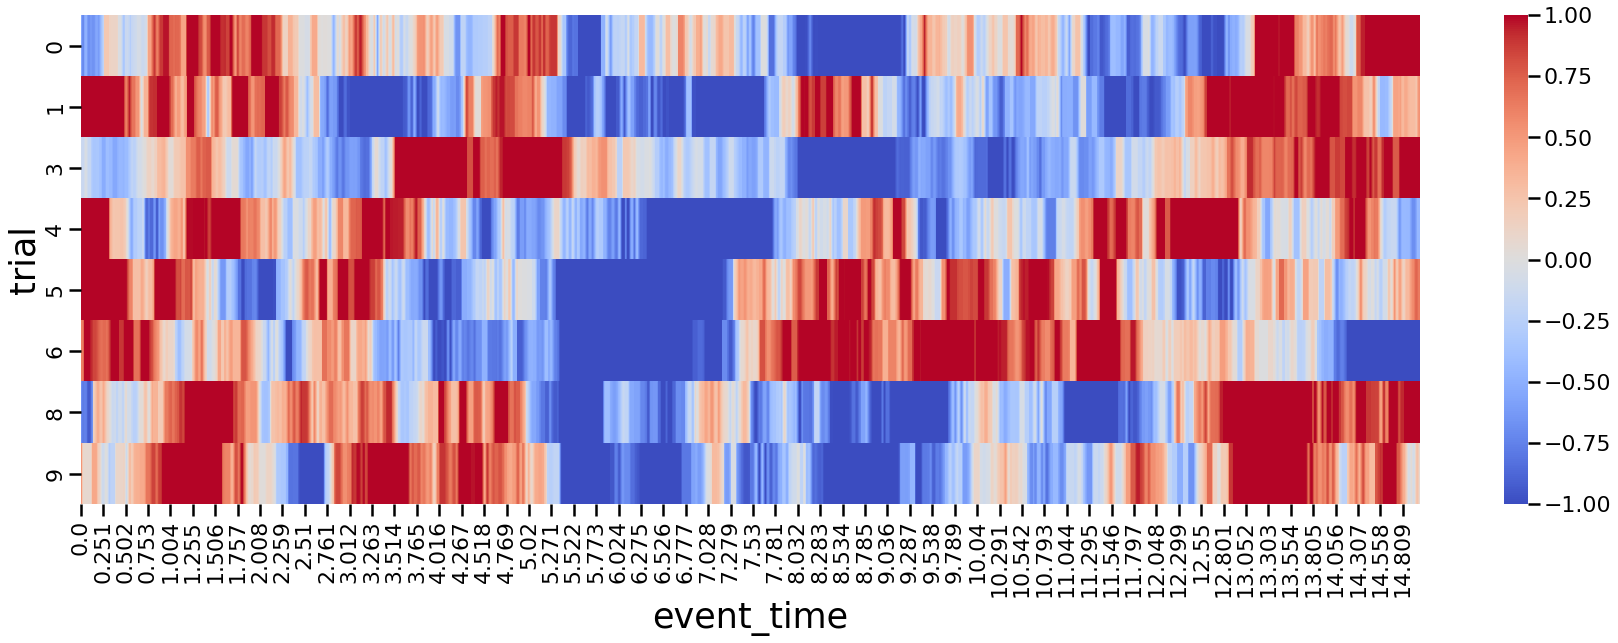

25.1


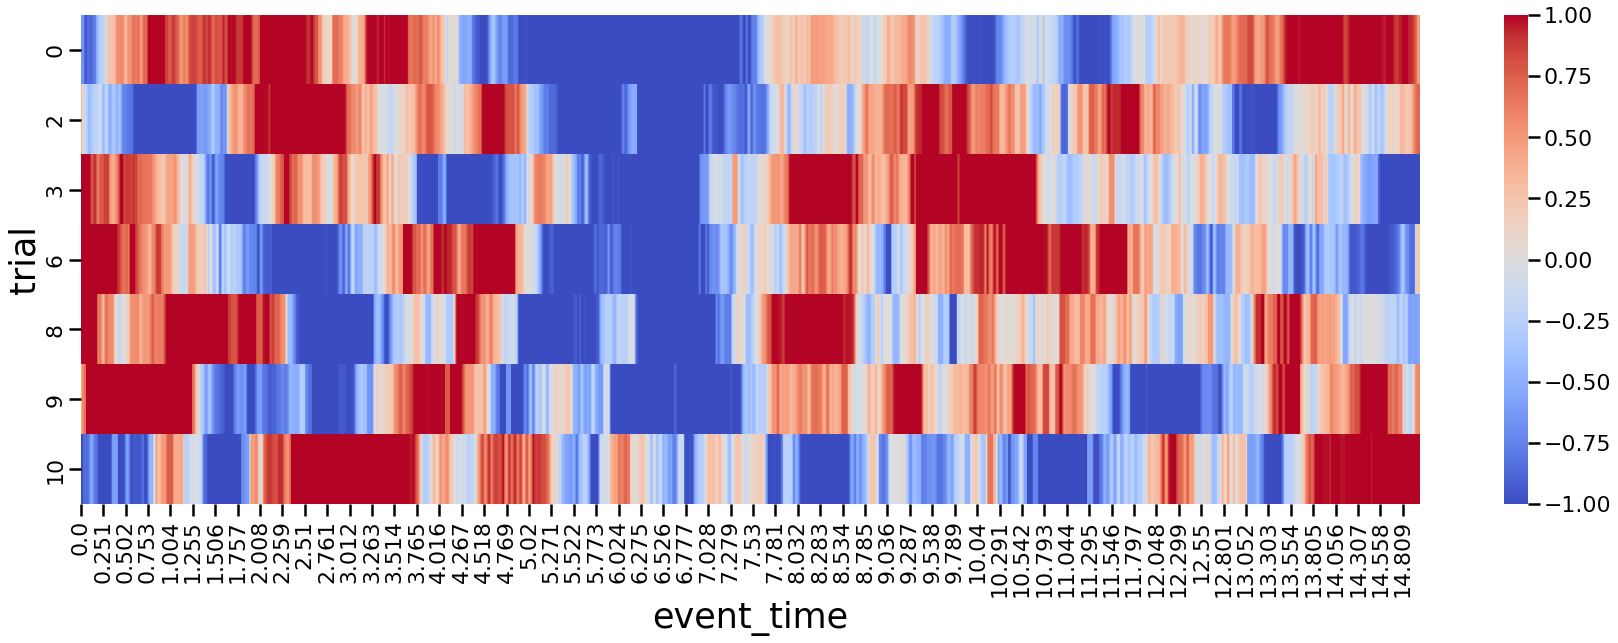

1609
50.1


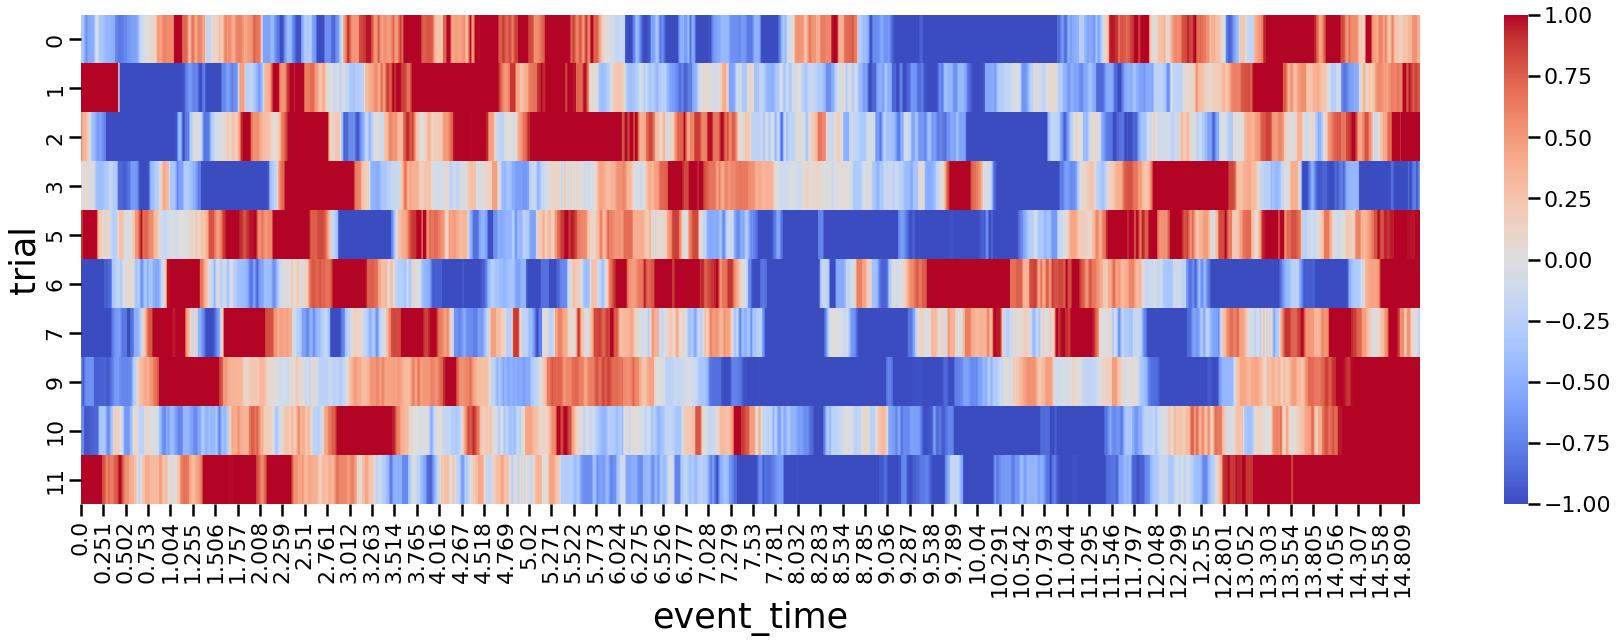

25.1


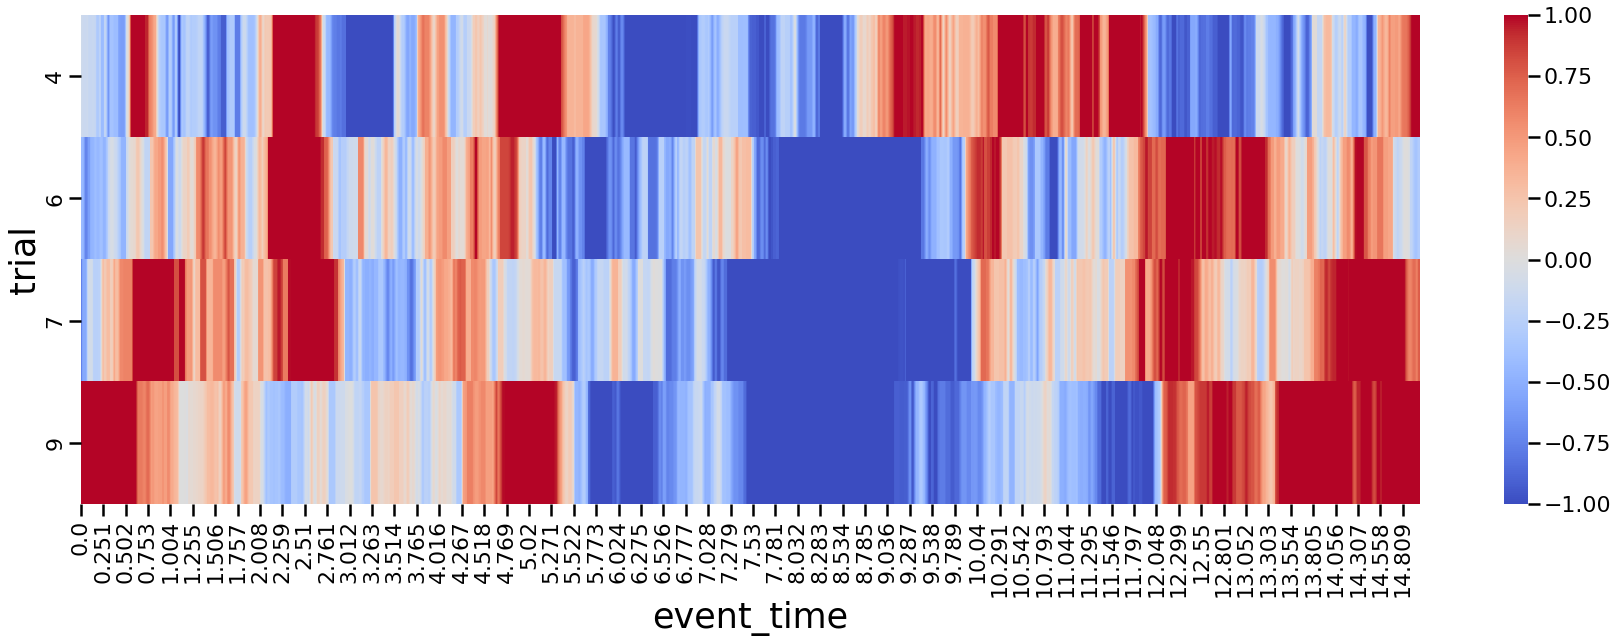

1607
50.1


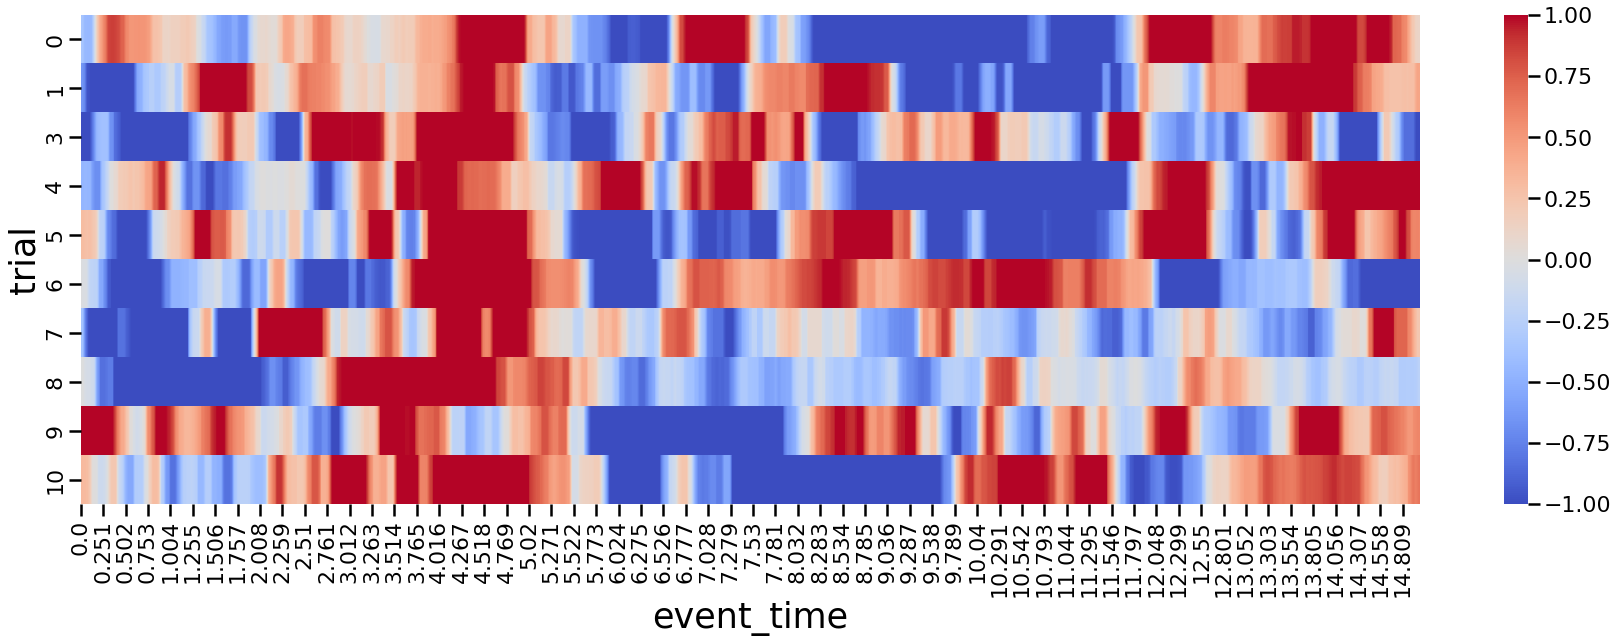

1600
50.1


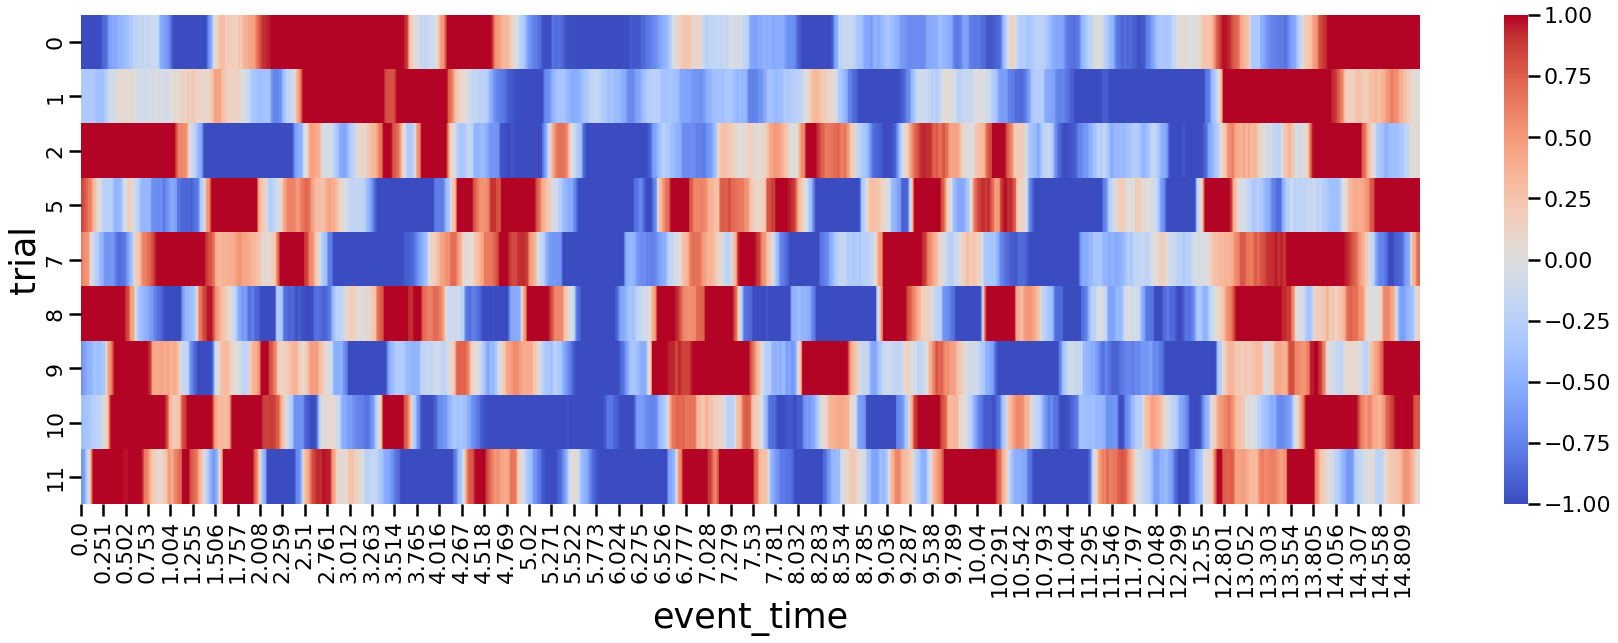

1598
50.1


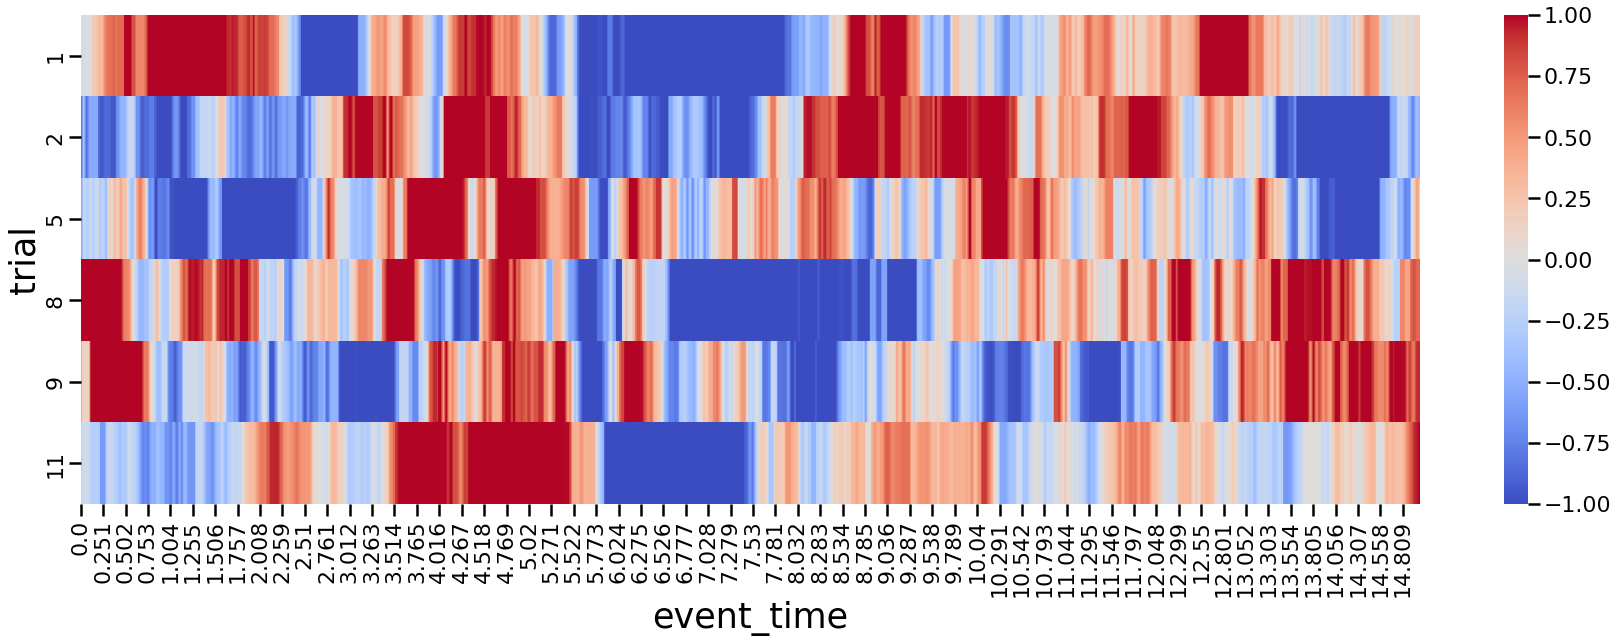

1597
50.1


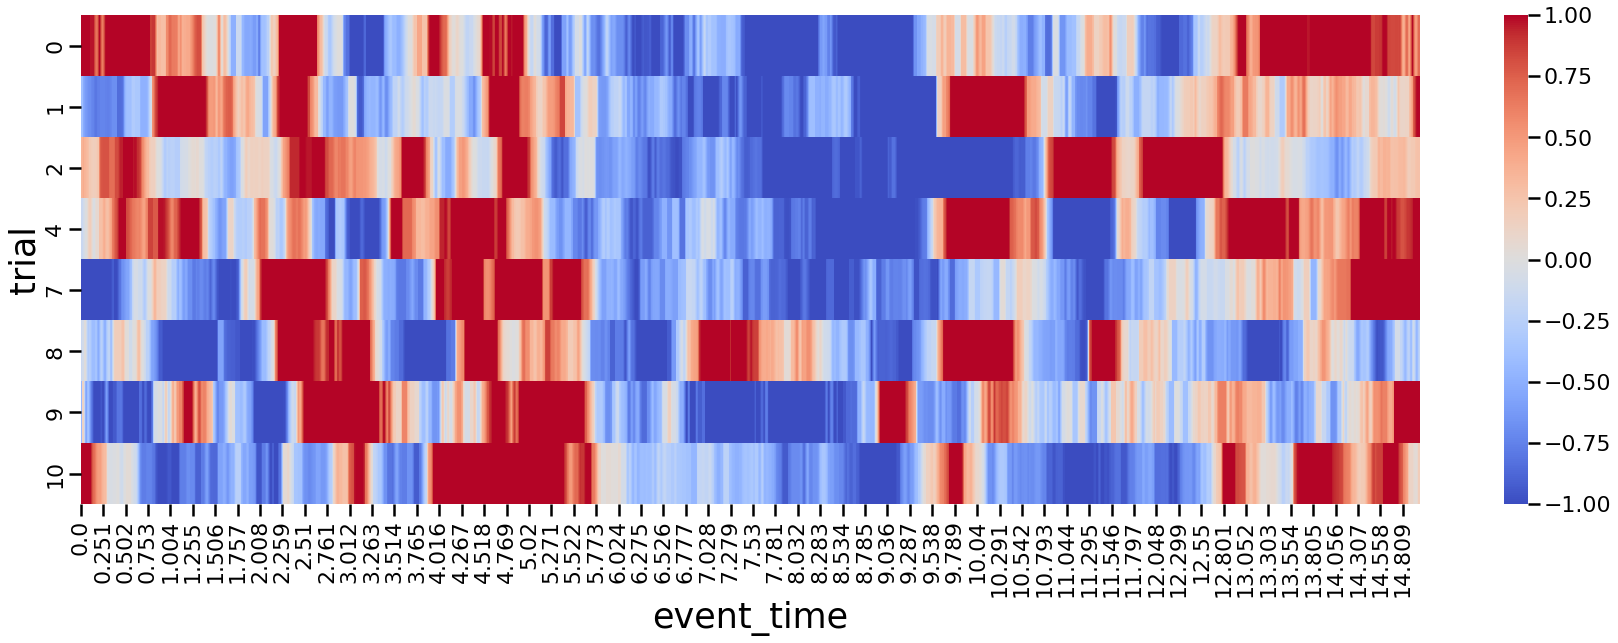

1596
50.1


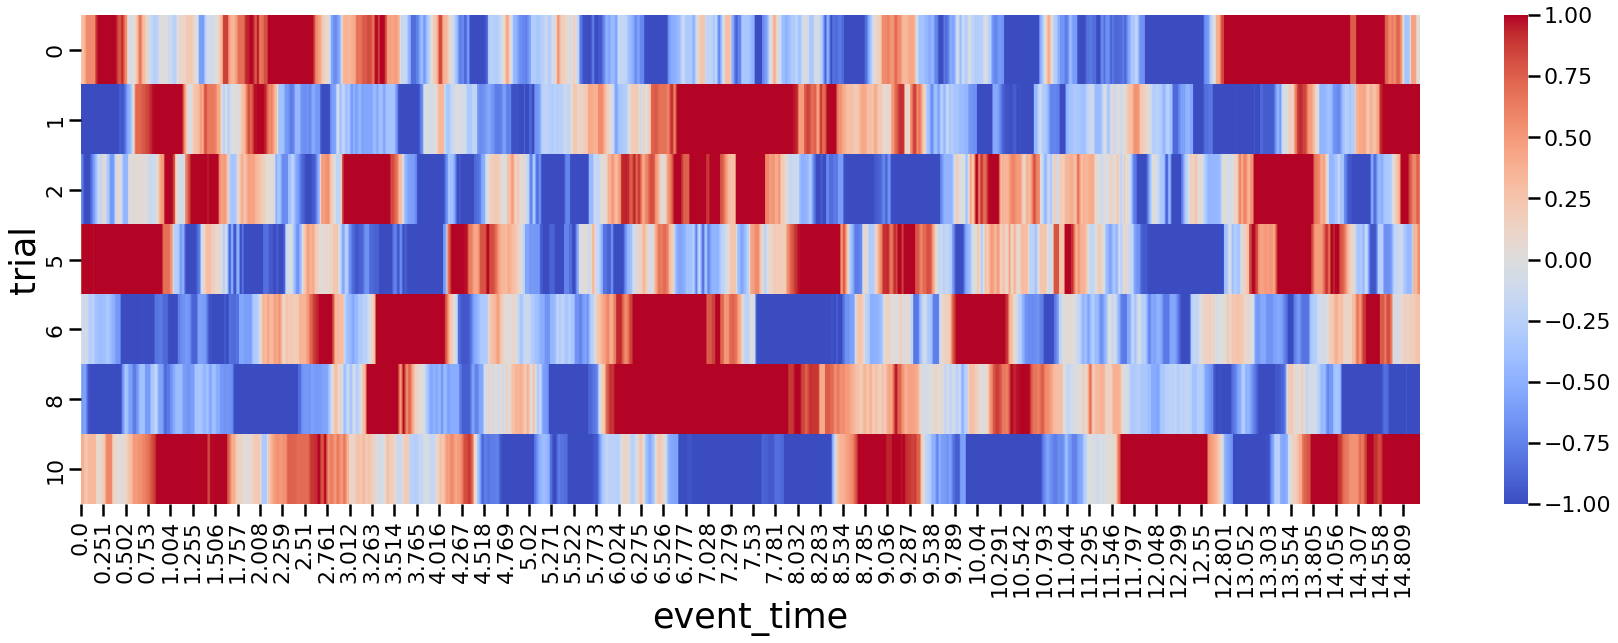

1605
50.1


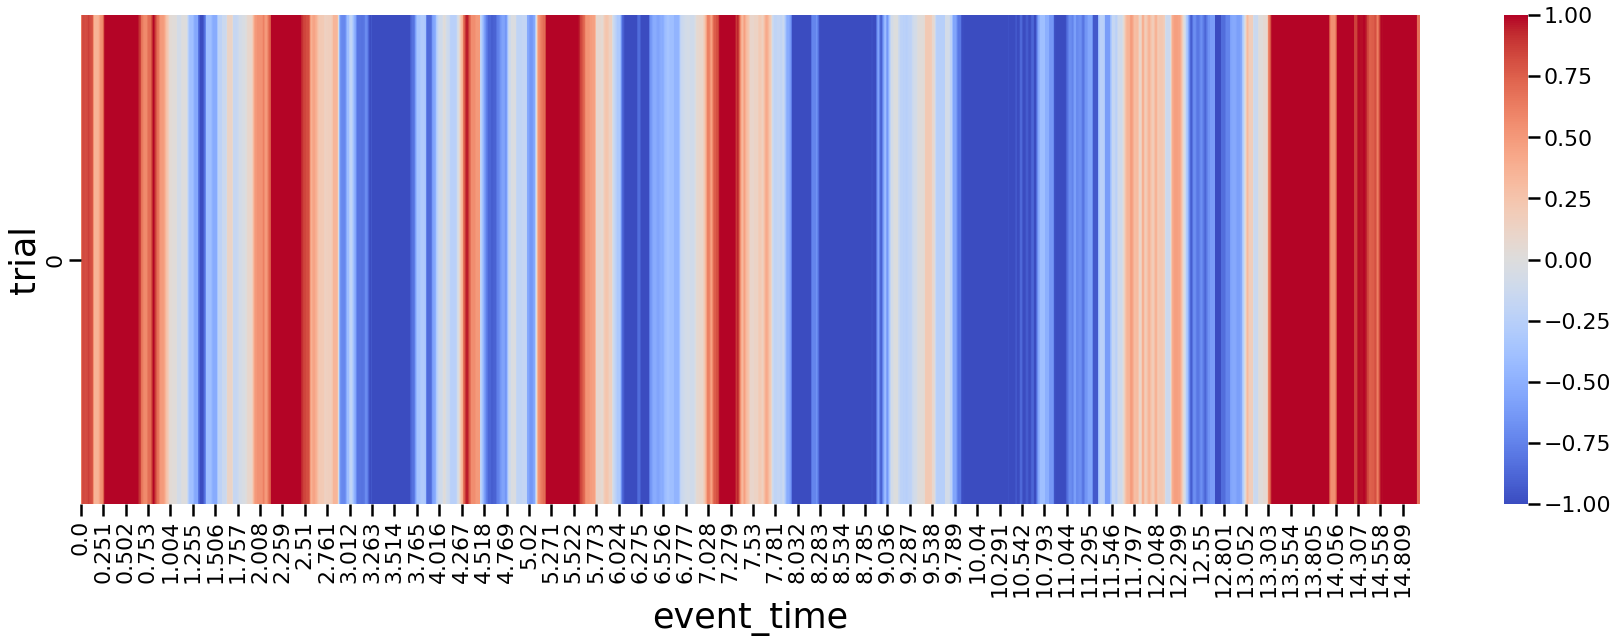

In [ ]:
for animal in PE_df['animal'].unique():
    print(animal)
    data_animal = PE_df[PE_df['animal']==animal]

    
    for session in data_animal['session'].unique():
        print(session)
        d = data_animal[data_animal['session']==session]
        d = d[d['event']=='right_press']

        groupby = d.groupby(['trial', 'event_time'])['FP_signal_medfilt'].mean().reset_index()
        groupby = groupby.pivot('trial', 'event_time', "FP_signal_medfilt")
        plt.figure(figsize=(30,9))
        ax = sns.heatmap(groupby, cmap="coolwarm", vmin=-1, vmax=1)
        plt.show()
        
        #plt.figure(figsize=(20,7))
        #sns.lineplot(x='event_time', y='FP_signal_medfilt', data=d[d['event']=='left_extend'], ci=None, n_boot=1, markers=True, hue='trial')
        #plt.show()